# TIØ4317 Project

Group members:
- Frederick Johan Pretlove
- Fabian Stoltenberg
- Hans Kristian Bjørgo Kværum
- Hedda Flemmen Holum

## Problem statement

This project investigates how fluctuations in the oil price, and the Norwegian Krone (NOK) exchange rate influence the stock prices of selected companies listed on the Oslo Stock Exchange (OSE). By applying time-series analysis, we aim to determine the explanatory power of these external economic factors in stock price prediction.

We will retrieve historical data via APIs (Yahoo Finance and Norges Bank) and implement ARIMA and ARIMAX models (see explanations in the “Empirical Analysis” section). Our goal is to compare their predictive performance and assess whether incorporating oil prices and exchange rates improves stock price forecasts beyond a baseline ARIMA model. If these external factors enhance predictive accuracy, this would indicate a relationship between commodity prices, exchange rates, and stock prices.

To ensure model robustness, we will conduct diagnostic tests for stationarity, autocorrelation, and heteroscedasticity. The findings will provide insights into the relationship between macroeconomic factors and energy stock prices, offering valuable guidance to investors and analysts seeking to better understand market dynamics.


In [12]:
#Imports
#Data manipulation and plotting
import pandas as pd #For reading files + data manipulation
import matplotlib.pyplot as plt  #For plotting
import numpy as np  #For data manipulation and calculations

#For statistical modelling
from statsmodels.tsa.stattools import adfuller #For ADF test
from statsmodels.tsa.stattools import kpss #For KPSS test
import warnings #To surpress KPSS warnings
from statsmodels.tsa.arima.model import ARIMA #For ARIMA modelling
from sklearn.metrics import mean_squared_error #For model evaluation

In [2]:
# Load the processed data 
df_commodities = pd.read_excel('Data/Processed/DAILY_COMMODITY_PRICES.xlsx')[['Date','Price','% Change', 'Ticker']]
df_stocks = pd.read_excel('Data/Processed/DAILY_STOCK_PRICES.xlsx')[['Date', 'Price', '% Return', 'Ticker']]
df_exchange_rate = pd.read_excel('Data/Processed/DAILY_EXCHANGE_RATES.xlsx')[['Date','Mid', '% Change', 'Ticker']]

## Data

Our project utilizes three datasets covering the period from January 2018 to February 2025, providing the necessary historical information for our time-series analysis.

The first dataset consists of daily stock prices for selected companies listed on the Oslo Stock Exchange. In addition to stock prices, this dataset includes features such as trading volume, daily percentage return, cumulative return percentage, and stock ticker symbols.


In [3]:
df_stocks.head()

,Date,Price,% Return,Ticker
0,2018-01-02,361.27866,0.637107,YAR-NO
1,2018-01-03,364.70940,0.949610,YAR-NO
2,2018-01-04,363.85170,-0.235174,YAR-NO
3,2018-01-05,367.28247,0.942903,YAR-NO
4,2018-01-08,375.09702,2.127668,YAR-NO


The second dataset contains daily exchange rates of various currencies against the Norwegian Krone (NOK), including USD/NOK, GBP/NOK, EUR/NOK, and CHF/NOK. This dataset provides information on bid and ask prices, percentage changes, and corresponding ticker symbols, allowing us to assess the impact of currency fluctuations on stock prices.


In [4]:
df_exchange_rate.head()

,Date,Mid,% Change,Ticker
0,2018-01-02,8.370757,-0.273562,CHFNOK
1,2018-01-03,8.306228,-0.770886,CHFNOK
2,2018-01-04,8.296742,-0.114203,CHFNOK
3,2018-01-05,8.254831,-0.505150,CHFNOK
4,2018-01-08,8.278486,0.286559,CHFNOK


The third dataset includes daily prices of gas and oil over the same timeframe. Alongside commodity prices, the dataset also includes percentage changes and ticker symbols.

In [5]:
df_commodities.head()

,Date,Price,% Change,Ticker
0,2018-01-02,50.781433,68.251837,HHGAS-FDS
1,2018-01-03,50.641342,-0.275871,HHGAS-FDS
2,2018-01-04,37.605713,-25.741081,HHGAS-FDS
3,2018-01-05,37.438774,-0.443919,HHGAS-FDS
4,2018-01-08,23.359003,-37.607457,HHGAS-FDS


The data was retrieved through Sparebank 1's internal database, as one of our group members has access. Before analysis, we conducted preprocessing steps, including handling missing values, aligning timestamps across datasets, and standardizing variables to ensure consistency.

For our empirical analysis, we focus on oil prices as our commodity variable and use the mean exchange rate (the average of the four exchange rates) to capture broader currency fluctuations. These variables are selected based on their potential impact on stock prices and their relevance to the Norwegian energy sector.


To get a better understanding of the data we are dealing with, we performed Exploratory Data Analysis (EDA).

### Stock price development for different stocks from 2018 to 2025

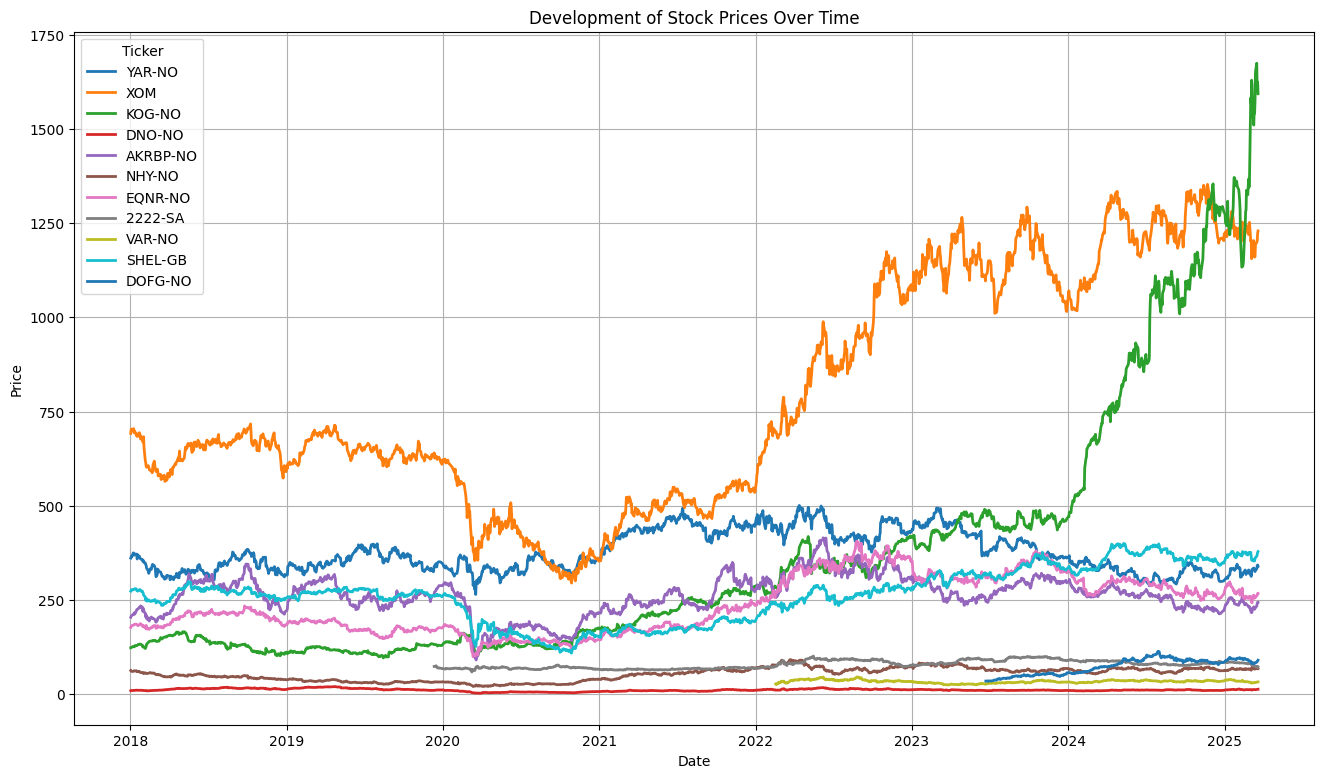

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
stock_prices = pd.read_excel('Data/Processed/DAILY_STOCK_PRICES.xlsx')

# Ensure the date is in the correct datetime format (if not already)
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])

# Get unique tickers
unique_tickers = stock_prices['Ticker'].unique()

# Prepare the plot
plt.figure(figsize=(16, 9))  # Specify a larger figure size for better clarity

# Generate a plot for each ticker
for ticker in unique_tickers:
    # Filter data for the current ticker
    data = stock_prices[stock_prices['Ticker'] == ticker]
    
    # Plotting
    plt.plot(data['Date'], data['Price'], label=f'{ticker}', marker='', linestyle='-', linewidth=2)

plt.title('Development of Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Ticker', loc='upper left')  # Legend with title
plt.grid(True)  # Adding grid for better readability
plt.show()

### Development of the oil price from 2018 to 2025

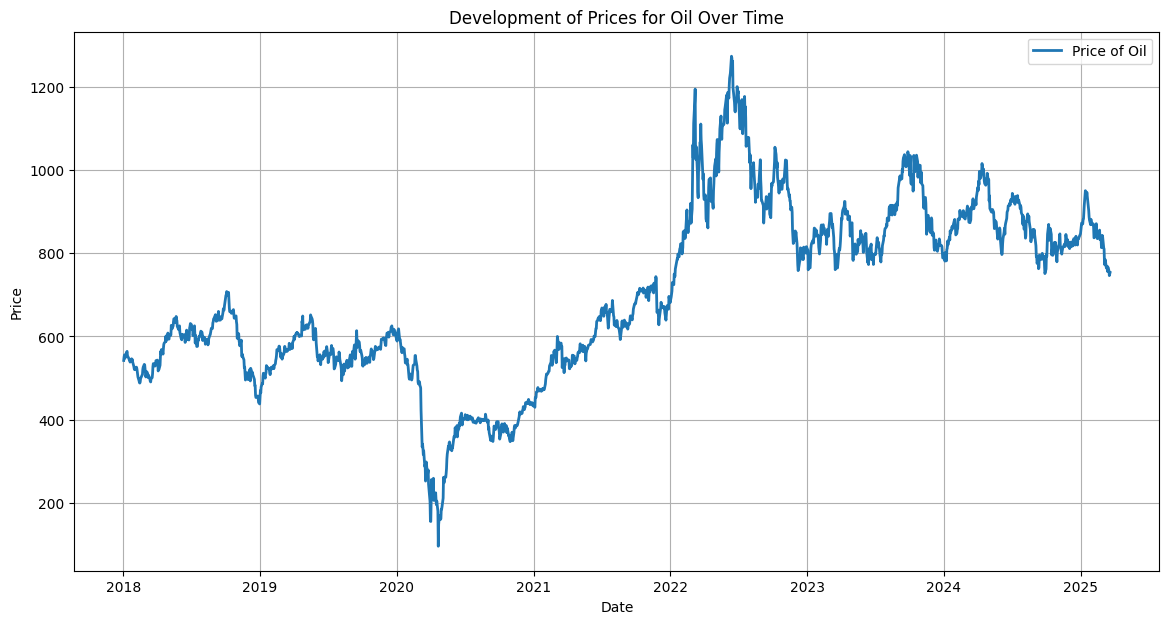

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
commodity_prices = pd.read_excel('Data/Processed/DAILY_COMMODITY_PRICES.xlsx')

# Ensure the date is in the correct datetime format (if not already)
commodity_prices['Date'] = pd.to_datetime(commodity_prices['Date'])


data = commodity_prices[commodity_prices['Ticker'] == 'OILDB-FDS']

# Create a graph for the oil price development
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Price'], label='Price of Oil', marker='', linestyle='-', linewidth=2)
plt.title('Development of Prices for Oil Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Development of exchange rates

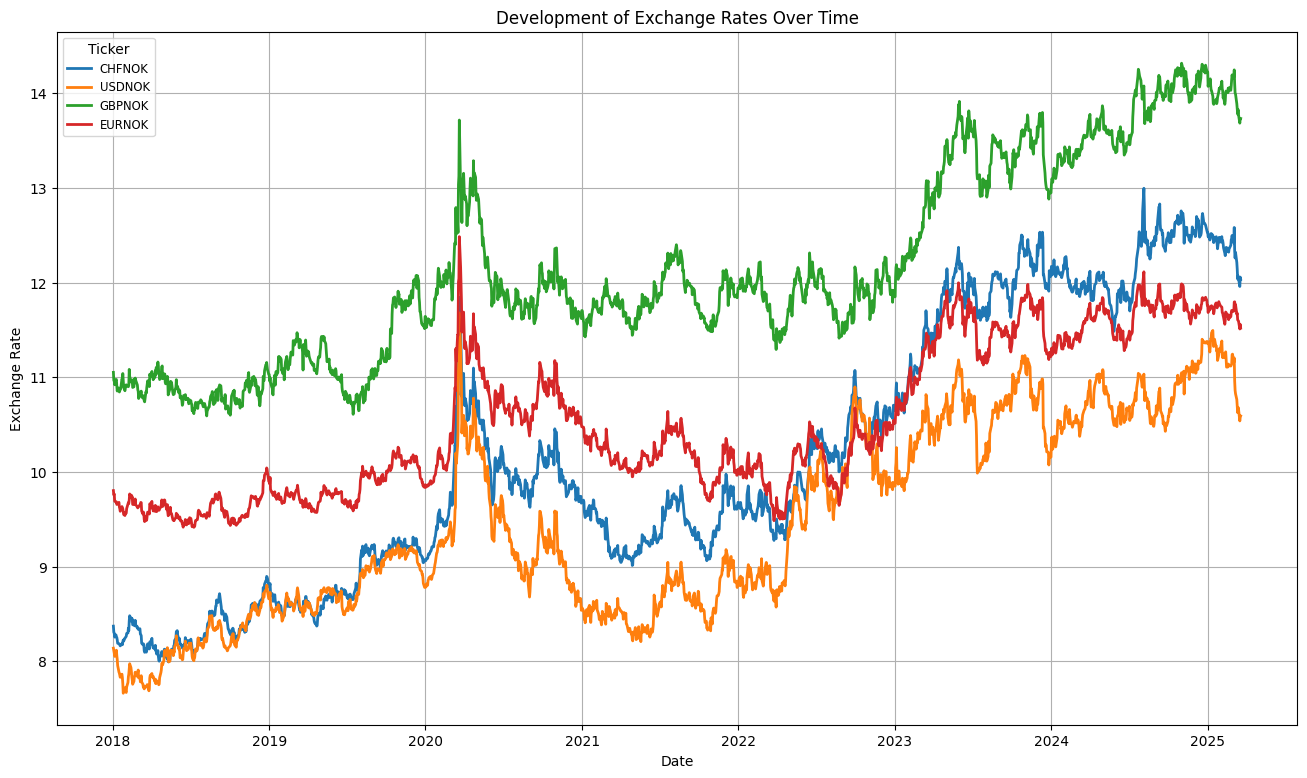

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
exchange_rates = pd.read_excel('Data/Processed/DAILY_EXCHANGE_RATES.xlsx')

# Ensure the date is in the correct datetime format (if not already)
exchange_rates['Date'] = pd.to_datetime(exchange_rates['Date'])

# Get unique tickers
unique_tickers = exchange_rates['Ticker'].unique()

# Prepare the plot
plt.figure(figsize=(16, 9))  # Set a larger figure size for better clarity

# Generate a plot for each ticker
for ticker in unique_tickers:
    # Filter data for the current ticker
    data = exchange_rates[exchange_rates['Ticker'] == ticker]
    
    # Plotting
    plt.plot(data['Date'], data['Mid'], label=f'{ticker}', marker='', linestyle='-', linewidth=2)

plt.title('Development of Exchange Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend(title='Ticker', loc='upper left', fontsize='small')  # Legend with title and adjust font size if needed
plt.grid(True)  # Adding grid for better readability
plt.show()

### Graphing energy stocks alongside oil price

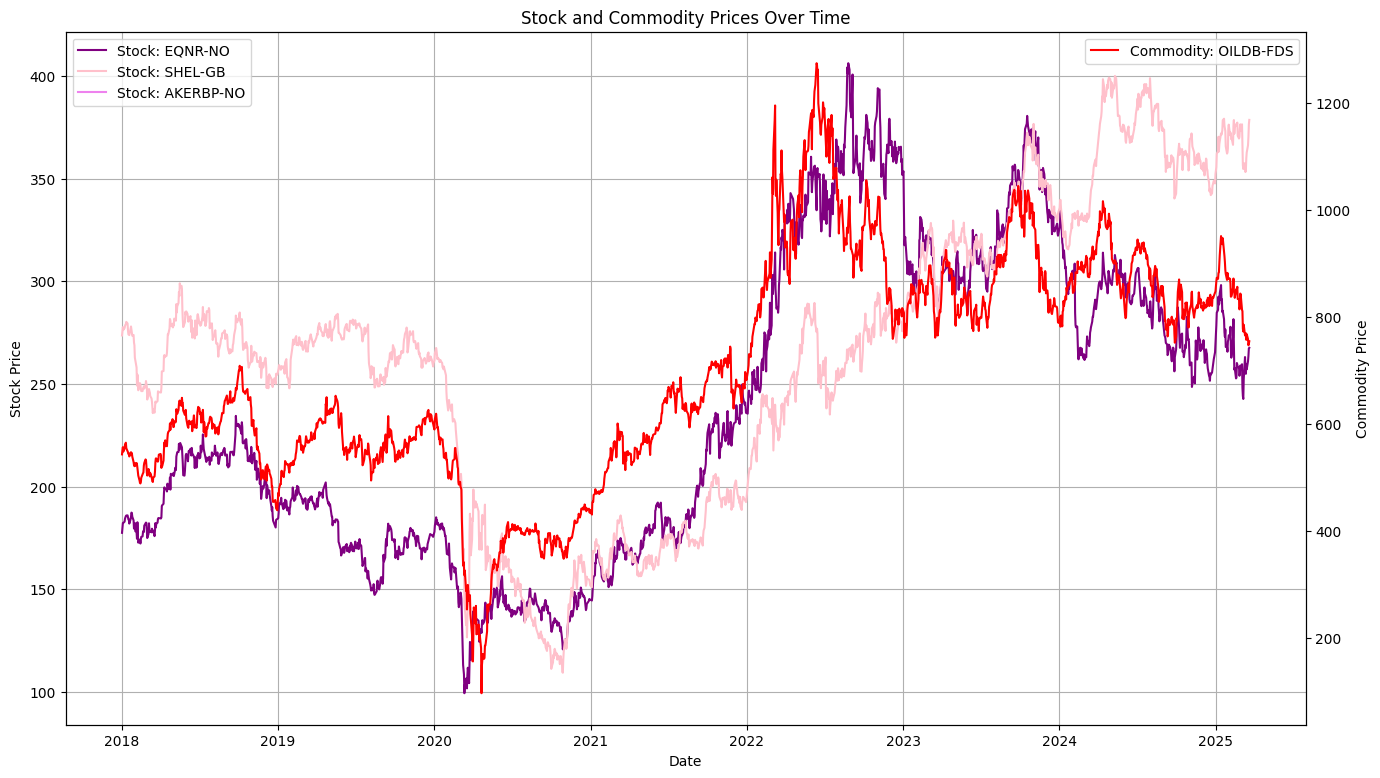

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
stock_prices = pd.read_excel('Data/Processed/DAILY_STOCK_PRICES.xlsx')
commodity_prices = pd.read_excel('Data/Processed/DAILY_COMMODITY_PRICES.xlsx')

# Ensure the date is in the correct datetime format
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])
commodity_prices['Date'] = pd.to_datetime(commodity_prices['Date'])

# Define the stocks and commodities to plot, with specific colors
stocks = {
    'EQNR-NO': 'purple',
    'SHEL-GB': 'pink',
    'AKERBP-NO': 'violet'
}
commodities = {
    'OILDB-FDS': 'red',
    #'HHGAS-FDS': 'blue',
    #'AECOCAD-FDS': 'green'
}

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(16, 9))

# Plot each stock on ax1
for stock, color in stocks.items():
    data = stock_prices[stock_prices['Ticker'] == stock]
    ax1.plot(data['Date'], data['Price'], label=f'Stock: {stock}', color=color)

# Set labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price')
ax1.set_title('Stock and Commodity Prices Over Time')

# Create a second y-axis for the commodities
ax2 = ax1.twinx()
for commodity, color in commodities.items():
    data = commodity_prices[commodity_prices['Ticker'] == commodity]
    ax2.plot(data['Date'], data['Price'], label=f'Commodity: {commodity}', linestyle='-', color=color)

# Set secondary y-axis label
ax2.set_ylabel('Commodity Price')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add grid and show plot
ax1.grid(True)
plt.show()


As can be seen from the plot above, the stock prices of Norwegian energy companies seem to follow the fluctuations of the oil price. It will therefore be interesting to investigate whether the stock price has some explanatory power on the stock price.

<h3 style="color:red;">Include graph here with energy sector stocks alongside mean exchange rate - with updated mean calculation (@Hans Kristian)</h3>


In [10]:
# Insert code here

<span style="color:red;">Add insight about exchange rate vs. stocks here<span>

## Empirical Analysis

In this section we will describe how we performed our empirical analysis. As mentioned in the problem statement, we implemented two time-series models; the ARIMA and ARIMAX models. 

ARIMA (AutoRegressive Integrated Moving Average) is a time-series forecasting model that relies on past values of the target variable and errors to make predictions. It consists of three components: the AutoRegressive (AR) part, which incorporates past values of the series; the Integrated (I) part, which ensures stationarity through differencing; and the Moving Average (MA) part, which accounts for past forecast errors. Since ARIMA only considers the historical behavior of the target variable without any external influences, it is classified as a univariate model.

ARIMAX (ARIMA with Exogenous Variables) extends ARIMA by incorporating external factors that may influence the target variable. In addition to the AR, I, and MA components, ARIMAX includes exogenous variables (X), which help explain variations in the target series. By integrating external variables, ARIMAX becomes a multivariate model, improving forecasting accuracy if the chosen factors have significant predictive power.


### Test for stationarity

A crucial assumption of the ARIMA models is stationarity. A stationary process is a time series whose statistical properties, such as mean, variance and autocorrelation are constant over time (Brooks pg.248). The behavior of the series is independent of when one observes it. 

There are several reasons for why stationarity is desirable. Firstly, shocks may persist infinitely in a non-stationary process. Random disturbances may cause permanent shifts in the series, making it difficult for models that assume mean-reverting properties to predict future values. Additionally, two non-stationary series can move together over time, producing artificially high $R^2$ despite having no true relationship. This effect is called spurious regressions and can result from trending behavior misinterpreted as correlation. Lastly, non-stationary data can cause the t-ratios to not follow a t distribution, making hypothesis testing about the regression parameters less reliable (Brooks pg.334-336). 

Since ARIMA relies on data being stationary, tests to detect non-stationarity are conducted. The Augmented Dicky-Fuller (ADF) Test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests are two statistical methods to investigate stationarity (Brooks pg. 347). This project will use both ADF and KPSS, as they test opposite things, and thus complement each other. The null hypothesis of ADF is that the time series is non-stationary, while KPSS’s null hypothesis is that the time series is stationary.

Both of these tests are pre-implemented in the Statsmodels package in Python. Note that the tests are conducted with a significane level of 5%, which is deemed to be industry standard. Before we conduct the stationarity tests, the datasets columns are renamed to ease data manipulation. Additionally, a dictionary is created to store data and results. 

<span style="color:red;">OBS Hans Kristian: dette påvirker kanskje kode din. Bare å endre ved behov<span>

In [ ]:
#Refine column names
df_commodities.columns = ['Date', 'Price', 'Change_percent', 'Ticker']
df_stocks.columns = ['Date', 'Price', 'Change_percent', 'Ticker']
df_exchange_rate.columns = ['Date', 'Price', 'Change_percent', 'Ticker']

#Print to ensure succesful renaming
print(df_commodities.head())
print(df_stocks.head())
print(df_exchange_rate.head())

#Create dictionary for data storage
stocks_dictionary = {}

for key, values in df_stocks.groupby('Ticker'):
    stocks_dictionary[key] = {
        'data': values[['Date', 'Change_percent']],
    }

        Date      Price  Change_percent     Ticker
0 2018-01-02  50.781433       68.251837  HHGAS-FDS
1 2018-01-03  50.641342       -0.275871  HHGAS-FDS
2 2018-01-04  37.605713      -25.741081  HHGAS-FDS
3 2018-01-05  37.438774       -0.443919  HHGAS-FDS
4 2018-01-08  23.359003      -37.607457  HHGAS-FDS
        Date      Price  Change_percent  Ticker
0 2018-01-02  361.27866        0.637107  YAR-NO
1 2018-01-03  364.70940        0.949610  YAR-NO
2 2018-01-04  363.85170       -0.235174  YAR-NO
3 2018-01-05  367.28247        0.942903  YAR-NO
4 2018-01-08  375.09702        2.127668  YAR-NO
        Date     Price  Change_percent  Ticker
0 2018-01-02  8.370757       -0.273562  CHFNOK
1 2018-01-03  8.306228       -0.770886  CHFNOK
2 2018-01-04  8.296742       -0.114203  CHFNOK
3 2018-01-05  8.254831       -0.505150  CHFNOK
4 2018-01-08  8.278486        0.286559  CHFNOK


#### Check stationarity of prices

Prices are known to potentially be non-stationary and follow a trend or drift. To confirm this, ADF and KPSS test are run on all stock and commodities prices, as well as exchange rate values.  

In [ ]:
#Check stock prices for stationarity, using ADF and KPSS tests, for each ticker

def check_stationarity(data, title, returns = False):

    results = []
    for key, grp in data.groupby(['Ticker']):
      
        series = grp['Price'] if not returns else grp['Change_percent']
        warnings.filterwarnings("ignore")  # Suppress KPSS warnings
        
        # ADF Test
        adf_result = adfuller(series)
        
        # KPSS Test
        kpss_result = kpss(series, regression='c', nlags='auto')
        
        
        conclusion = 'error'
        # Interpretation of results
        #Clear cases
        if adf_result[1] < 0.05 and kpss_result[1] > 0.05: #ADF reject null: shows stationary, KPSS fail to reject null: shows stationary
            conclusion = 'Stationary'
            
        elif adf_result[1] > 0.05 and kpss_result[1] < 0.05: #ADF fail to reject null: shows non-stationary, KPSS reject null: shows non-stationary
            conclusion = 'Non-Stationary'
           
        #Unclear cases, conflicting results
        elif adf_result[1] < 0.05 and kpss_result[1] < 0.05: #ADF reject null: shows stationary, KPSS reject null: shows non-stationary
            conclusion = 'Conflicting Results: only KPSS flags non-statio'
         
        elif adf_result[1] > 0.05 and kpss_result[1] > 0.05: #ADF fail to reject null: shows non-stationary, KPSS fail to reject null: shows stationary
            conclusion = 'Conflicting Results: only ADF shows non-statio'
           
        else:
            print("Error")
            
        #Create a df summary
        results.append({
            'Type': title,
            'Ticker': key,
            'Conlusion': conclusion,
        })
    return pd.DataFrame(results)

summary1 = check_stationarity(df_stocks, 'Stock Prices Stationarity')
summary2 = check_stationarity(df_commodities, 'Commodities Prices Stationarity')
summary3 = check_stationarity(df_exchange_rate, 'Exchange Rate Prices Stationarity')

#Merge the summaries
summary = pd.concat([summary1, summary2, summary3])
display(summary)

,Type,Ticker,Conlusion
0,Stock Prices Stationarity,"(2222-SA,)",Non-Stationary
1,Stock Prices Stationarity,"(AKRBP-NO,)",Conflicting Results: only KPSS flags non-statio
2,Stock Prices Stationarity,"(DNO-NO,)",Non-Stationary
3,Stock Prices Stationarity,"(DOFG-NO,)",Non-Stationary
4,Stock Prices Stationarity,"(EQNR-NO,)",Non-Stationary
5,Stock Prices Stationarity,"(KOG-NO,)",Non-Stationary
6,Stock Prices Stationarity,"(NHY-NO,)",Non-Stationary
7,Stock Prices Stationarity,"(SHEL-GB,)",Non-Stationary
8,Stock Prices Stationarity,"(VAR-NO,)",Conflicting Results: only KPSS flags non-statio
9,Stock Prices Stationarity,"(XOM,)",Non-Stationary


As expected, most of these prices and values are non-stationary, and cannot be used as input to an ARIMA model. Interestingly, the stock prices of AkerBP (AKERBP-NO) and Vår Energi (VAR-NO), as well as the commodity price of Natural gas (HNNGAS-FDS) show signs of stationarity, with the ADF test and KPSS test returning conflicting results. This can be due to the prices of these tickers having a relatively stable trend.

#### Check stationarity of returns

Next, stock returns are investigated for non-stationarity. 

In [14]:
#Confirm that returns are stationary
summary1 = check_stationarity(df_stocks, 'Stock Returns Stationarity', returns=True)
summary2 = check_stationarity(df_commodities, 'Commodities Returns Stationarity', returns=True)
summary3 = check_stationarity(df_exchange_rate, 'Exchange Rate Returns Stationarity', returns=True)

summary = pd.concat([summary1, summary2, summary3])
display(summary)


,Type,Ticker,Conlusion
0,Stock Returns Stationarity,"(2222-SA,)",Stationary
1,Stock Returns Stationarity,"(AKRBP-NO,)",Stationary
2,Stock Returns Stationarity,"(DNO-NO,)",Stationary
3,Stock Returns Stationarity,"(DOFG-NO,)",Stationary
4,Stock Returns Stationarity,"(EQNR-NO,)",Stationary
5,Stock Returns Stationarity,"(KOG-NO,)",Stationary
6,Stock Returns Stationarity,"(NHY-NO,)",Stationary
7,Stock Returns Stationarity,"(SHEL-GB,)",Stationary
8,Stock Returns Stationarity,"(VAR-NO,)",Stationary
9,Stock Returns Stationarity,"(XOM,)",Stationary


Importantly, as seen in the output above, all returns are confirmed to be stationary, which is to be expected. To satisfy ARIMA's stationarity requirement, returns will be used for modelling.

### Forecasting with ARIMA

After preprocessing the data, and confirming stationarity, we can now proceed with ARIMA modelling. The ARIMA model will be the baseline model of this project to investigate whether including external factors such as oil return or change in currency rates can help improve stock return predictions. 

#### Divide data into training and test sets

For forecasting, dividing the data into training and test data is essential. It is important that the model is not evaluated on data which it already has seen, as this can lead to unrealistically high model performance. Therefore, it is common to hold out some data for testing, called a holdout sample (Brooks, pg.278). There are several ways to construct a holdout sample. The simplest way to achieve this is to use the first 80% of the data as training data, while the last 20% is used as test data. This is done below.

Note that since we split on number of rows, and not date, each ticker may have training and test windows with different start and end date.

In [15]:
#First, we create a dataset for each ticker, saved in a dictionary
stock_one_prediction = {}


for key, grp in df_stocks.groupby('Ticker'):
    copy = grp.copy()
    split_idx = int(len(copy) * 0.8) #80% of data for traning
    train = copy[:split_idx]
    test = copy[split_idx:]
    stock_one_prediction[key] = {  #Save train, test and actual data in dictionary for easy access
    "train": train,
    "test": test,
    "actual": copy
    }


summary_data = []

for ticker, data in stock_one_prediction.items():
    train_df = data['train']
    test_df = data['test']

    summary_data.append({
        'Ticker': ticker,
        'Train_Start': train_df['Date'].iloc[0],
        'Train_End': train_df['Date'].iloc[-1],
        'Test_Start': test_df['Date'].iloc[0],
        'Test_End': test_df['Date'].iloc[-1]
    })

date_summary_df = pd.DataFrame(summary_data)

# Display the result
print(date_summary_df)

      Ticker Train_Start  Train_End Test_Start   Test_End
0    2222-SA  2019-12-12 2024-02-28 2024-02-29 2025-03-20
1   AKRBP-NO  2018-01-02 2023-10-10 2023-10-11 2025-03-20
2     DNO-NO  2018-01-02 2023-10-06 2023-10-09 2025-03-20
3    DOFG-NO  2023-06-23 2024-11-08 2024-11-11 2025-03-20
4    EQNR-NO  2018-01-02 2023-10-11 2023-10-12 2025-03-20
5     KOG-NO  2018-01-02 2023-10-13 2023-10-16 2025-03-20
6     NHY-NO  2018-01-02 2023-10-09 2023-10-10 2025-03-20
7    SHEL-GB  2018-01-02 2023-10-11 2023-10-12 2025-03-20
8     VAR-NO  2022-02-17 2024-08-05 2024-08-06 2025-03-20
9        XOM  2018-01-02 2023-10-06 2023-10-09 2025-03-20
10    YAR-NO  2018-01-02 2023-10-11 2023-10-12 2025-03-20


#### Finding optimal ARIMA parameters

To implement an ARIMA model, the Box-Jenkins Approach was used (Brooks, pg.269). The first step of this approach consists in identifying the order of the model required to accurately capture the relationships of the data. With the use of returns, stationarity is insured and no differencing is needed. Therefore, the parameter d=0 and the ARIMA model reduces to an ARMA model. As this project focuses on stock prediction, ARMA models for stocks only will be implemented. For each stock, the parameters p (capturing the underlying autoregressive processes) and q (capturing the underlying moving average processes) are estimated using a grid search. To find a compromise between runtime and accuracy, the grid search is chosen to be of size 6*6. The information criteria AIC can be used to model find the optimal ARIMA paramters. 


In [16]:
#Note: As this is a grid search, the runtime can be quite long. On our PC this cell has a runtime of 2m 3s
#So please give the code some time to run

def arima_parameter_search(data):
    aic_results = [] 
    for p in range(6):
        for q in range(6):
            try:
                model = ARIMA(data['Change_percent'], order=(p, 0, q)).fit()
                aic_results.append((p, q, model.aic))
            except:
                continue

    best_aic = sorted(aic_results, key=lambda x: x[2])[0]


    return best_aic[0], best_aic[1]

result_stock = []

# Stocks
for key, value in stock_one_prediction.items():
    print(f"Processing {key}")
    p_aic, q_aic= arima_parameter_search(value['train'])
    result_stock.append({
        'Type': 'Stock',
        'Ticker': key,
        'AIC_parameters': (p_aic, 0, q_aic),
    })
    stock_one_prediction[key].update({'AIC': (p_aic,0, q_aic)})
    #update the dictionary with AIC parameters
    stocks_dictionary[key].update({'order': (p_aic, 0, q_aic)})



# Combine into DataFrames
result_stock_df = pd.DataFrame(result_stock)

# Display
display(result_stock_df)





Processing 2222-SA
Processing AKRBP-NO
Processing DNO-NO
Processing DOFG-NO
Processing EQNR-NO
Processing KOG-NO
Processing NHY-NO
Processing SHEL-GB
Processing VAR-NO
Processing XOM
Processing YAR-NO


,Type,Ticker,AIC_parameters
0,Stock,2222-SA,"(2, 0, 2)"
1,Stock,AKRBP-NO,"(5, 0, 5)"
2,Stock,DNO-NO,"(2, 0, 5)"
3,Stock,DOFG-NO,"(0, 0, 0)"
4,Stock,EQNR-NO,"(3, 0, 1)"
5,Stock,KOG-NO,"(4, 0, 4)"
6,Stock,NHY-NO,"(3, 0, 2)"
7,Stock,SHEL-GB,"(5, 0, 2)"
8,Stock,VAR-NO,"(0, 0, 0)"
9,Stock,XOM,"(5, 0, 4)"


The above output shows the optimal parameters found for each stock. It is to be noted that for some stocks the optimal parameters are found to be (0,0,0). This corresponds to the most basic model, just a white noise process. The predictions with an ARIMA(0,0,0) model will simply be the mean. The time series for these stocks may not have any significant autocorrelation. This is to be expected, as daily stock returns act as white noise. Additionally, this highlights the need for exploring more complex models such as ARIMAX, which also include the factors of external variables. Nevertheless, when considering AIC, 9 out of 11 stocks do have non-zero model parameters, highlighting the potential usefulness of predicting stocks using autocorrelation information and ARMA.

#### Fitting the model

The second step of the Box-Jenkins approach involves fitting the ARMA model with the parameters found in the previous step. Firstly, a one-shot-prediction model is fitted. For each stock, a ARMA model is trained on the first 80% of the time series. The obtained model is then used to predict the last 20% of the data all at once. This means that the first datapoint in the testset is predicted using the same model as the last datapoint in the testset, ignoring the behavior of the stock in between. 

Below the code for a one-shot-prediction, as well as plots showing the forecasts, are presented.

 

In [26]:
# Fit both the AIC and BIC models to the training data
#Note: runtime of 7 seconds

def evaluate_arima_models(data_dict):
   
    for key, value in data_dict.items():
       #Train and test series
        train_series = value['train']['Change_percent']
        test_series = value['test']['Change_percent']
        
       
        # Fit the model
        model_aic = ARIMA(train_series, order=value['AIC']).fit()
    

        # Forecast on test data
        aic_forecast = model_aic.forecast(steps=len(test_series))
        
        # Evaluate RMSE, sign and flip accuracy
        aic_rmse = np.sqrt(mean_squared_error(test_series, aic_forecast))
        sign_accuracy = np.mean(np.sign(test_series.values) == np.sign(aic_forecast.values))    

        actual_flips = np.sign(test_series.values[:-1]) != np.sign(test_series.values[1:])
        pred_flips = np.sign(aic_forecast.values[:-1]) != np.sign(aic_forecast.values[1:])
        correct_flips = actual_flips == pred_flips
        flip_accuracy = np.mean(correct_flips)
       
        
        # Store results
        data_dict[key].update({
            'AIC_model': model_aic,
            'AIC_forecast': aic_forecast,
            'AIC_RMSE': aic_rmse,
            'AIC_sign_accuracy': sign_accuracy,
            'AIC_flip_accuracy': flip_accuracy

        })

evaluate_arima_models(stock_one_prediction)



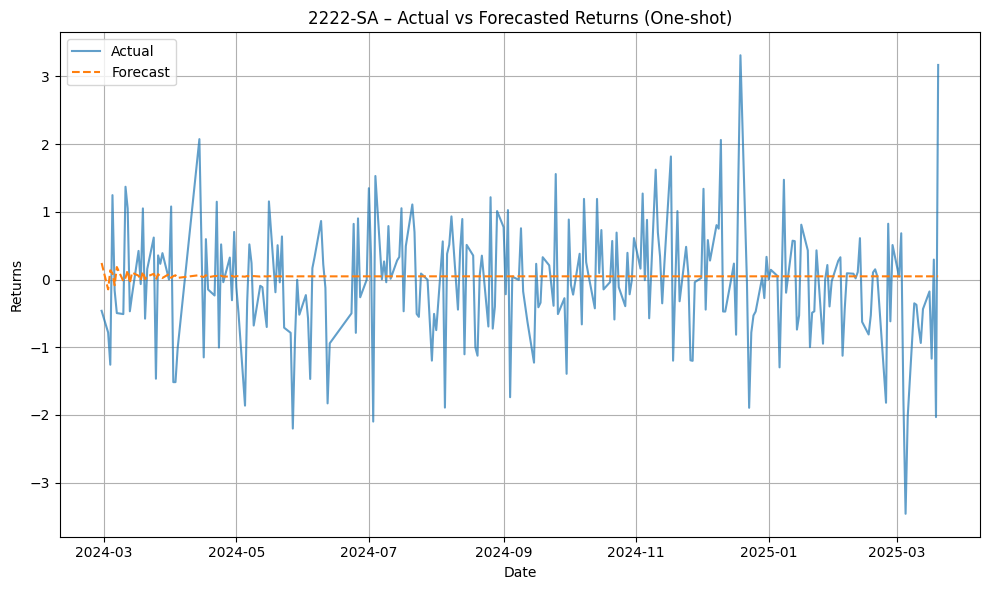

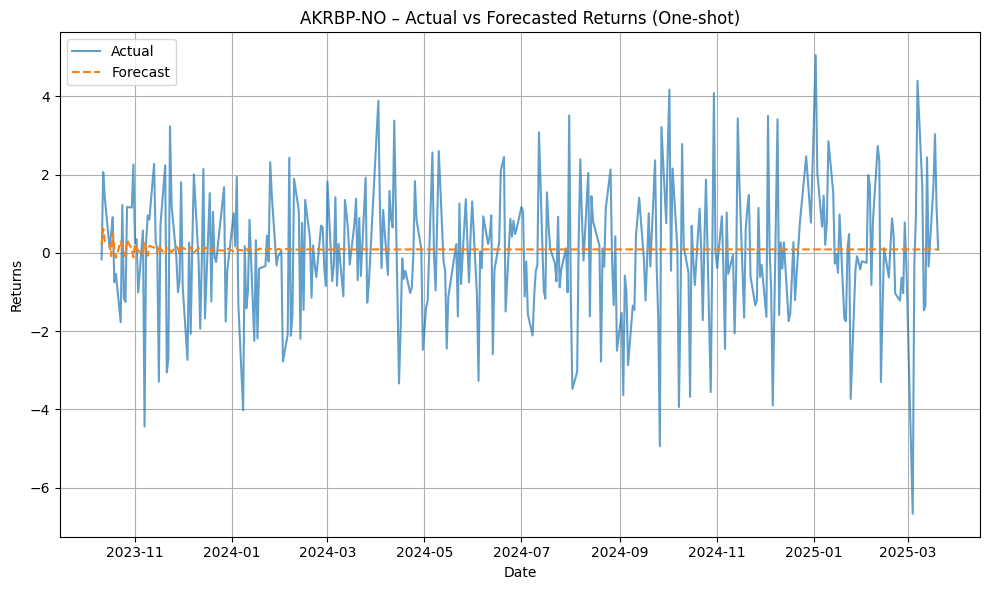

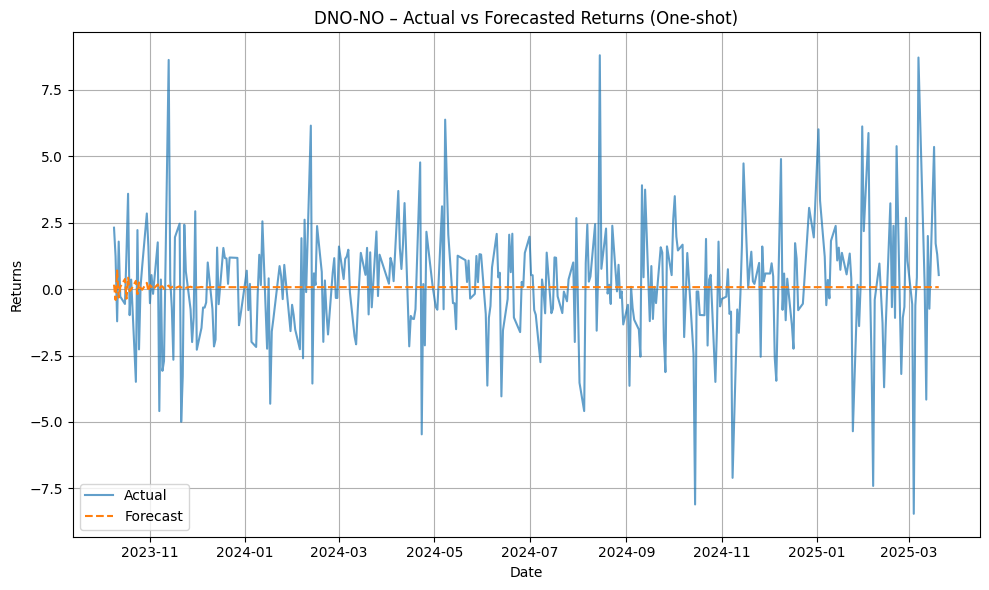

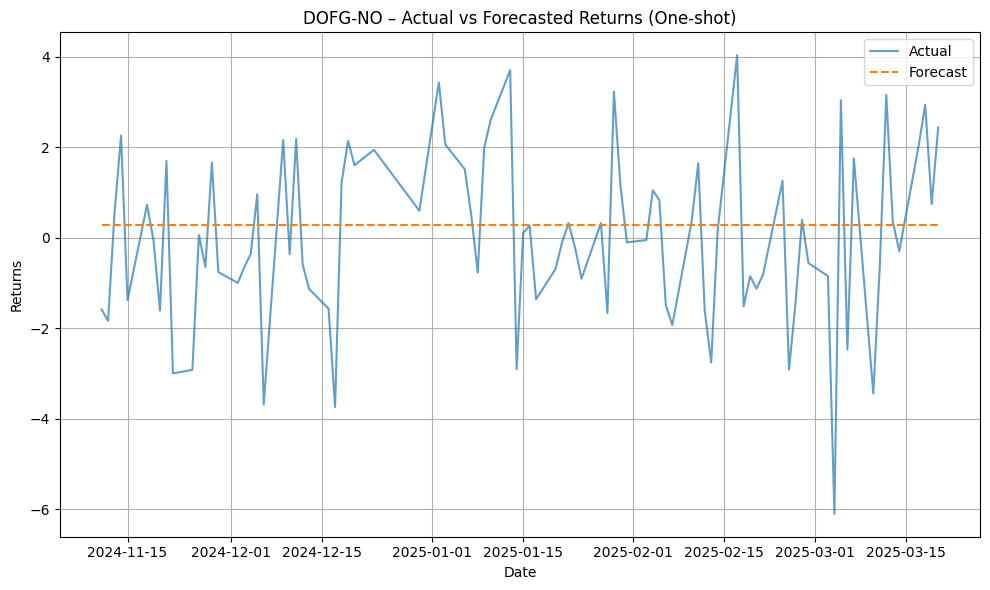

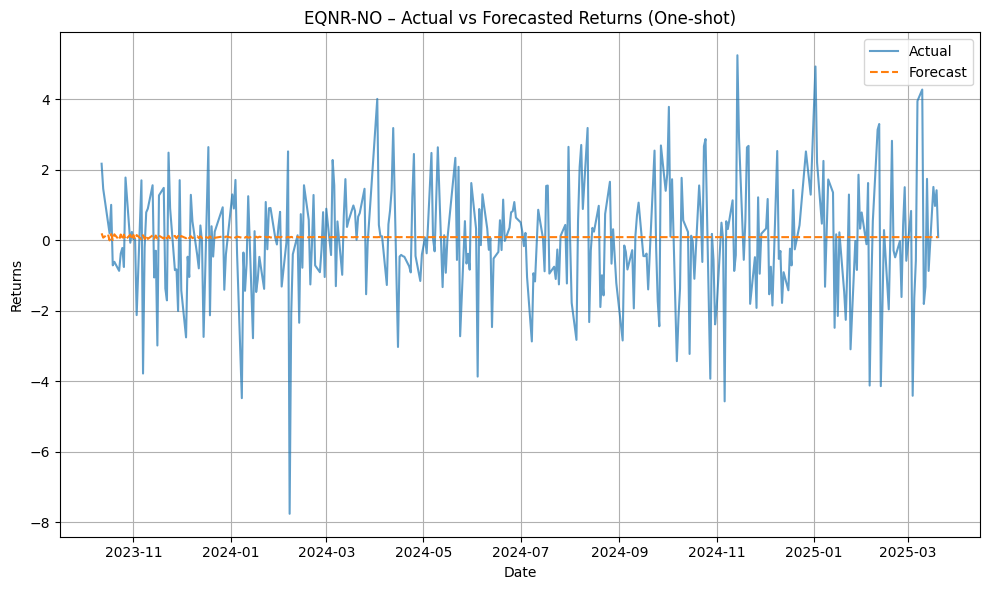

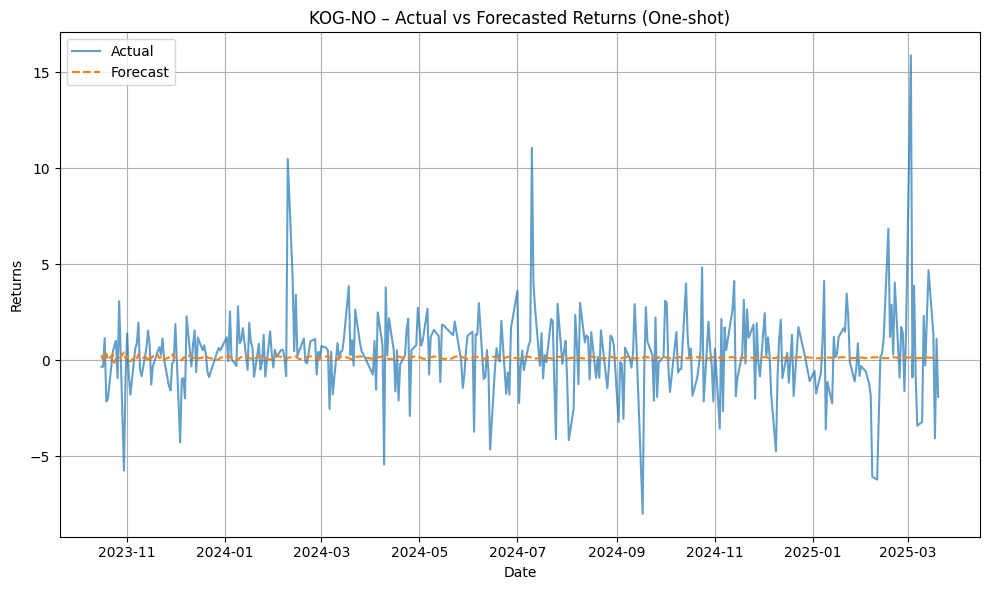

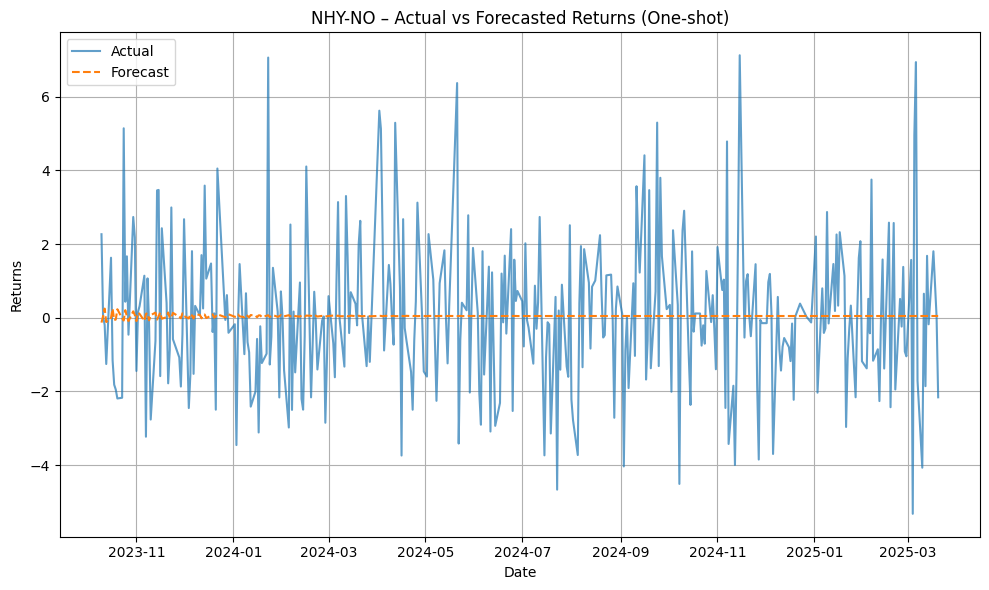

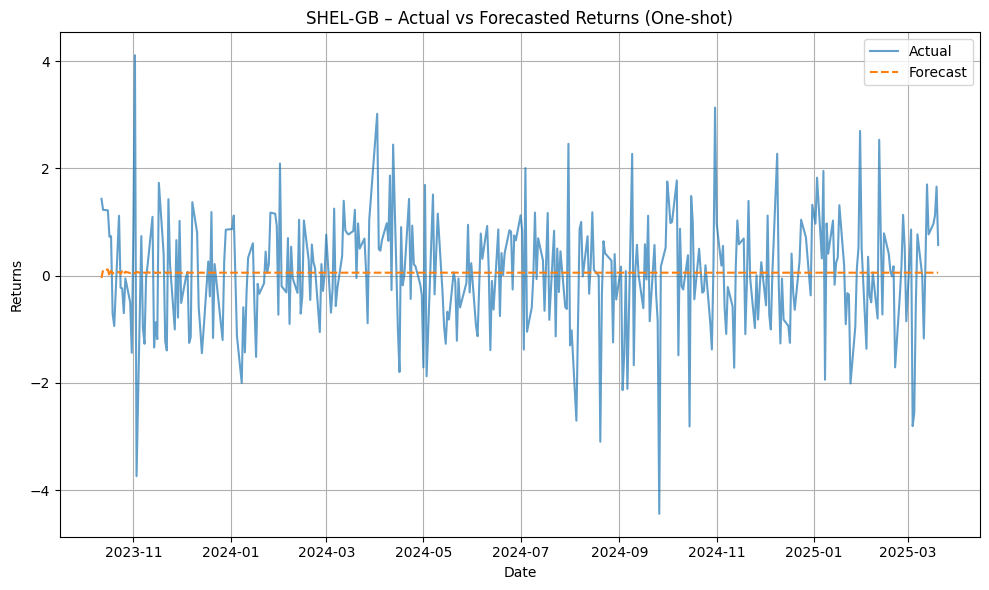

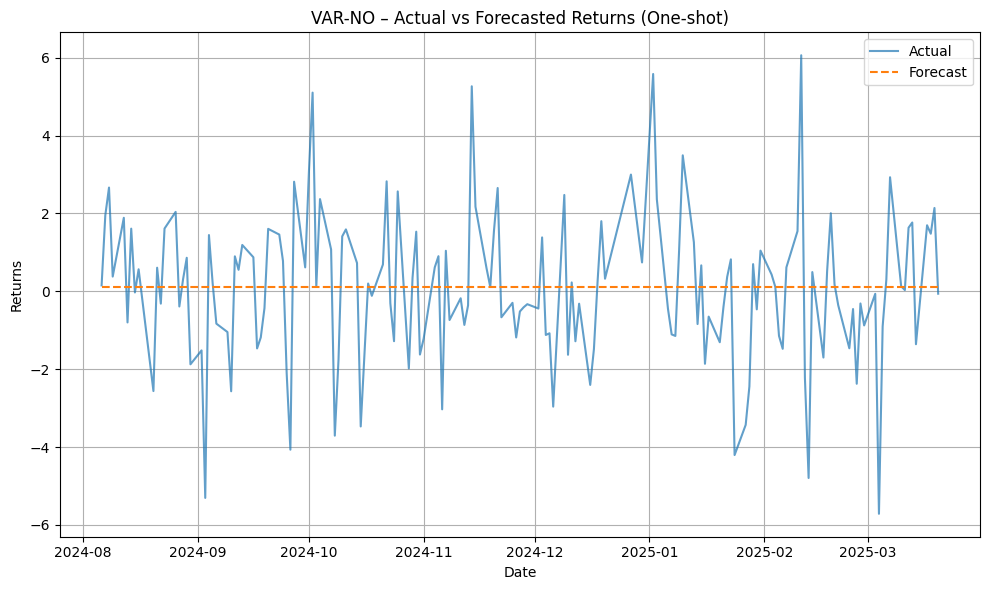

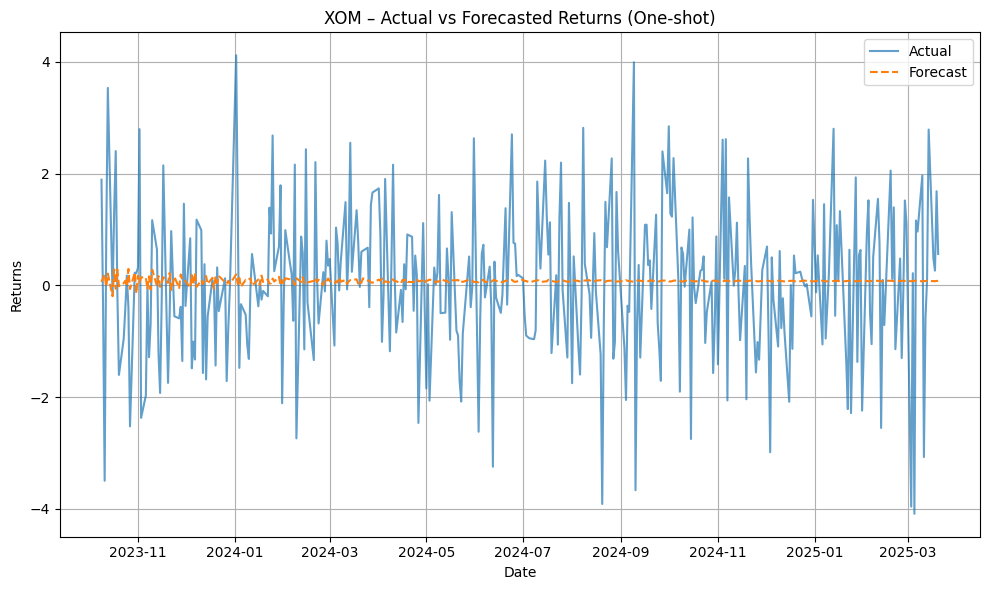

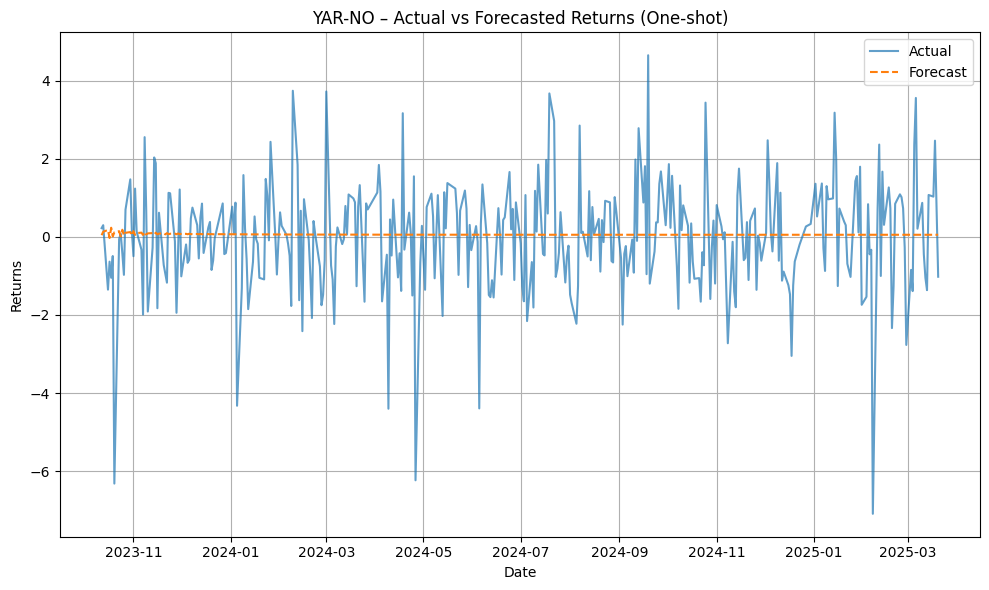

In [27]:
def plot_forecasts(data_dict):
    for key, value in data_dict.items():
        test_dates = value['test']['Date'].reset_index(drop=True)
        actual_returns = value['test']['Change_percent'].reset_index(drop=True)
        aic_forecast = pd.Series(value['AIC_forecast']).reset_index(drop=True)

        plt.figure(figsize=(10, 6))
        plt.plot(test_dates, actual_returns, label='Actual', alpha=0.7)
        plt.plot(test_dates, aic_forecast, label='Forecast', linestyle='--')

        plt.title(f"{key} – Actual vs Forecasted Returns (One-shot)")
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_forecasts(stock_one_prediction)

The plots above show that the predictions, at least visually, are not very good. While the predictions somewhat follow the stock return for the first few days, they quickly converge towards the mean return. As daily stock returns usually resemble white noise processes, the mean is expected to be around zero, causing flat predictions. For the ARMA(0,0) processes, the stock price is constantly predicted to be around the mean. These insights highlight the limitation of one-short forecasting with ARMA models. These models are short-memory processes, mainly capturing autocorrelation over recent lags. Therefore, they are inappropriate for forecasting predictions well into the future without updating the model.
 
The one-off prediction ARMA model is just a baseline model. A more in-depth evaluation of later models will follow in the section "Evaluating the Model". For now, the model is solely evaluated visually.

#### Rolling window predictions

The poor performance of the one-shot-prediction ARMA models motivate the use of rolling training windows, where the model both is continuously updated with new data and solely focuses on short-term forecasting. This model fitting strategy leverages the properties of ARMA models in a better way. 

The rolling window prediction is constructed in the following way. The window-size is set to 100, which means that all ARMA models are fitted based on 100 days of past stock returns. Each ARMA model is used to only predict the next days’ stock returns. The first prediction, for example, is obtained by fitting an ARMA model on the first 100 days of stock returns, and then predicting the stock return of the 101st day of the dataset. To predict the stock return of day 102, the window is shifted forwards by one day. A new ARMA model is fitted on the stock returns from day 1 to day 101, and used to predict the stock return on day 102. This process continues until stock returns for all days, excluding the first 100 days (the first window), are predicted. As seen in the plots, this approach captures the movement of the stock returns in much higher accuracy, over the whole period of the time series. 

Below a function is created to implement a rolling ARIMA model. To ensure code reproducibility, the below function also already supports ARIMAX integration. The plots below show the visual results of the forecasts. Note that the code has a long run time, around 20 minutes on our PCs. 



In [20]:
def evaluate_arima_or_arimax_rolling(data_dict, window_size=100, model_type="ARIMA", exog_key=None):
    """
    model_type: "ARIMA" or "ARIMAX"
    exog_key: name of the exogenous variable column (used only for ARIMAX)
    """
    results_summarized = pd.DataFrame()
    for key, value in data_dict.items():
        print(f"Processing {key} with model: {model_type}...")
        
        df = value['data'].copy()
        series = df['Change_percent']

        order = value['order'] 

        preds = []
        actuals = []
        residuals = []

        for i in range(window_size, len(series) - 1):
            train_window = series.iloc[i - window_size:i]
            test_point = series.iloc[i]

            try:
                if model_type == "ARIMAX":
                    exog_train = df[exog_key].iloc[i - window_size:i]
                    exog_test = df[exog_key].iloc[i + 0: i + 1]  # 1-step ahead

                    model = ARIMA(train_window, exog=exog_train, order=order).fit()
                    forecast = model.forecast(steps=1, exog=exog_test).iloc[0]

                else:  # ARIMA
                    model = ARIMA(train_window, order=order).fit()
                    forecast = model.forecast(steps=1).iloc[0]

                preds.append(forecast)
                actuals.append(test_point)
                residuals.append(test_point - forecast)

            except Exception as e:
                #Error at step {i}, do not let program crash, continue with predictions
                continue
        # Evaluate RMSE
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        
        #Calculate sign and flip accuracy
        sign_accuracy = np.mean(np.sign(actuals) == np.sign(preds))    

        actual_flips = np.sign(actuals[:-1]) != np.sign(actuals[1:])
        pred_flips = np.sign(preds[:-1]) != np.sign(preds[1:])
        correct_flips = actual_flips == pred_flips
        flip_accuracy = np.mean(correct_flips)
        

        # Save results
        value.update({
            f'{model_type}_Rolling_RMSE': rmse,
            f'{model_type}_Rolling_Predictions': preds,
            f'{model_type}_Rolling_Actuals': actuals,
            f'{model_type}_Rolling_Residuals': residuals,
            f'{model_type}_Rolling_Sign_Accuracy': sign_accuracy,
            f'{model_type}_Rolling_Flip_Accuracy': flip_accuracy

        })

        print(f"{key}: {model_type} RMSE = {rmse:.4f}")


        # Store results in a dataframe
        results_local = pd.DataFrame([{
            'Ticker': key,
            'Model': model_type,
            'RMSE': rmse,
            'Sign Accuracy': sign_accuracy,
            'Flip accuracy': flip_accuracy,
        }])

        # Append to the overall results
        results_summarized = pd.concat([results_summarized, results_local], ignore_index=True)
    
    return results_summarized

In [21]:

#Train models for each ticker 
results_rolling_arima = evaluate_arima_or_arimax_rolling(stocks_dictionary, window_size=100, model_type="ARIMA", exog_key=None)

Processing 2222-SA with model: ARIMA...
2222-SA: ARIMA RMSE = 1.2501
Processing AKRBP-NO with model: ARIMA...
AKRBP-NO: ARIMA RMSE = 2.7984
Processing DNO-NO with model: ARIMA...
DNO-NO: ARIMA RMSE = 3.4307
Processing DOFG-NO with model: ARIMA...
DOFG-NO: ARIMA RMSE = 2.2039
Processing EQNR-NO with model: ARIMA...
EQNR-NO: ARIMA RMSE = 2.0692
Processing KOG-NO with model: ARIMA...
KOG-NO: ARIMA RMSE = 2.3625
Processing NHY-NO with model: ARIMA...
NHY-NO: ARIMA RMSE = 2.4000
Processing SHEL-GB with model: ARIMA...
SHEL-GB: ARIMA RMSE = 20.3192
Processing VAR-NO with model: ARIMA...
VAR-NO: ARIMA RMSE = 2.0294
Processing XOM with model: ARIMA...
XOM: ARIMA RMSE = 4.1528
Processing YAR-NO with model: ARIMA...
YAR-NO: ARIMA RMSE = 1.9227


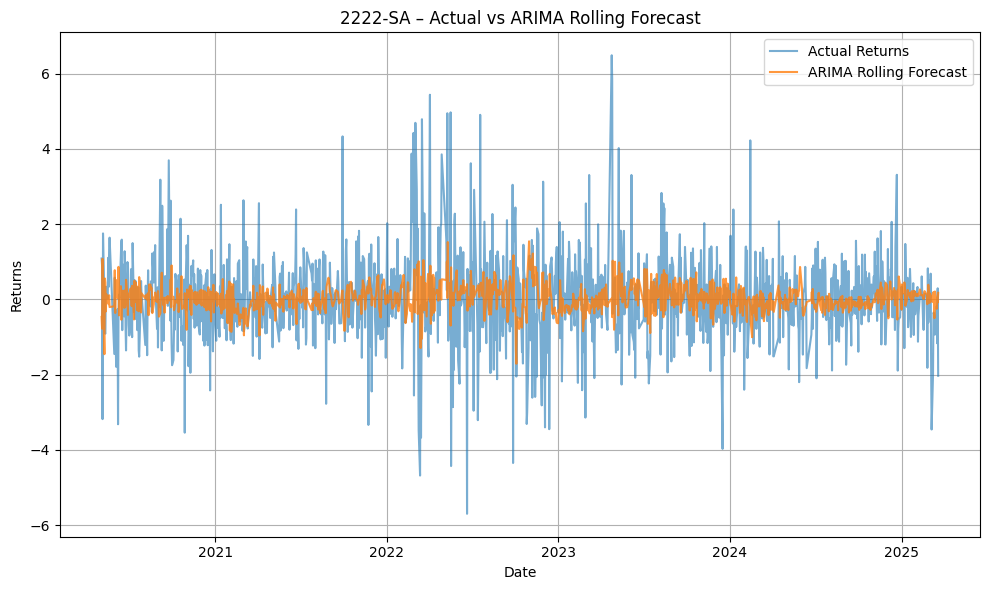

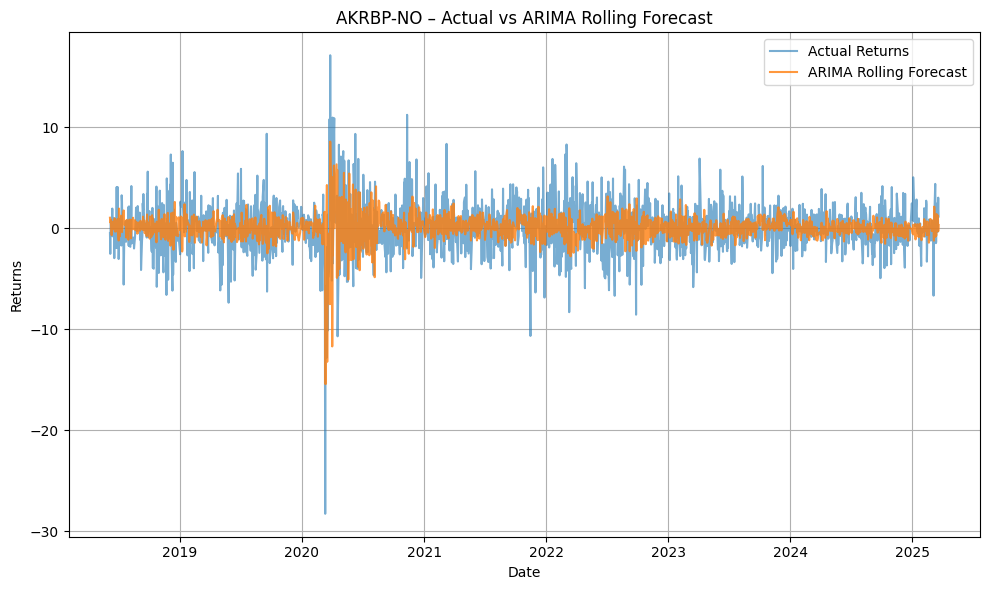

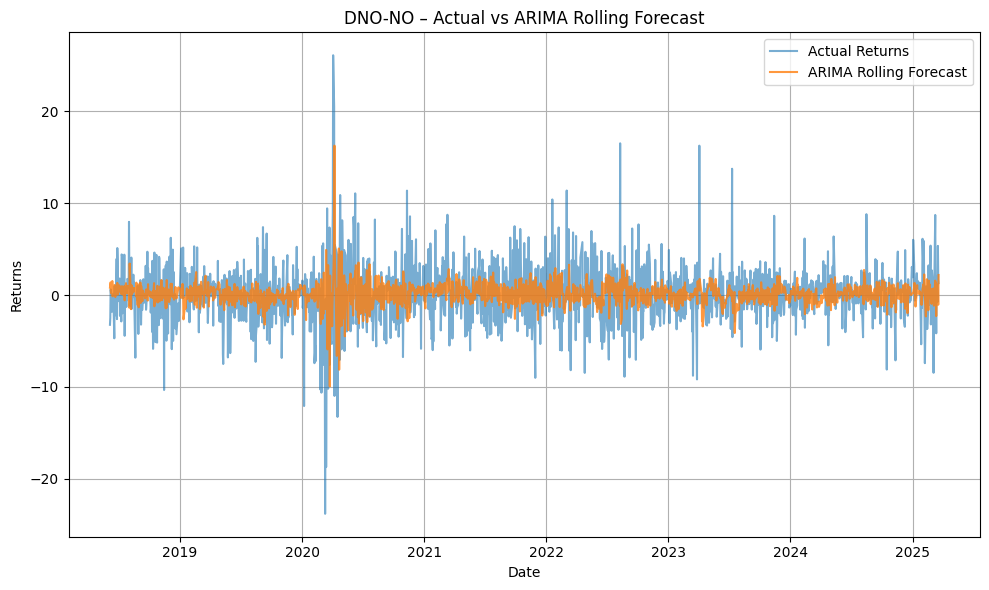

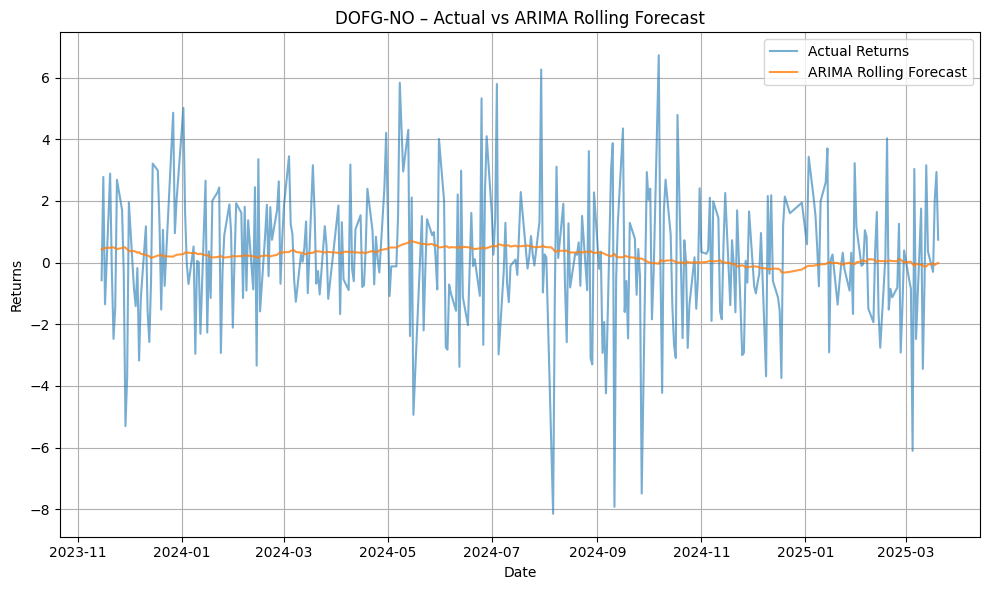

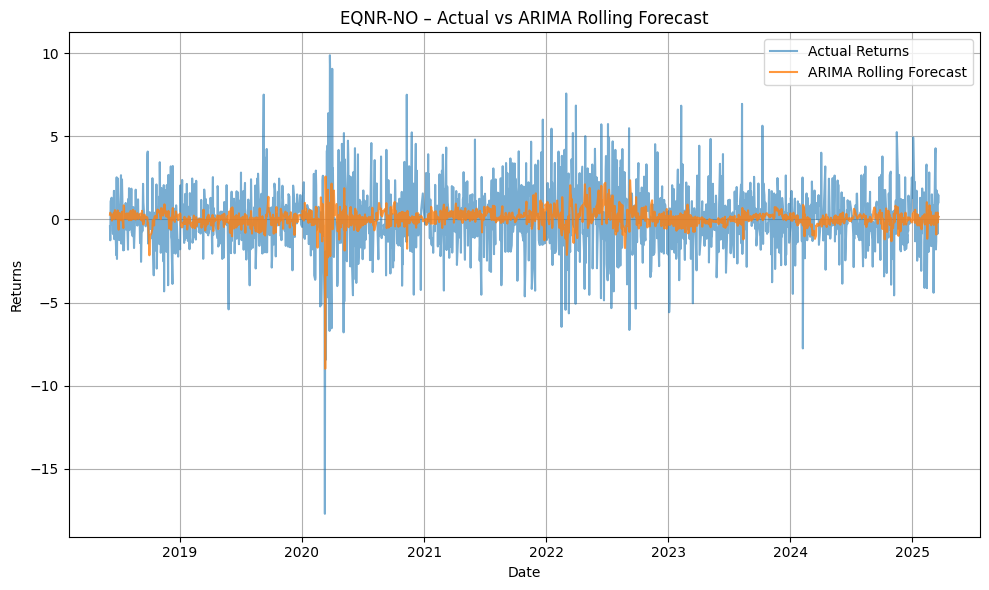

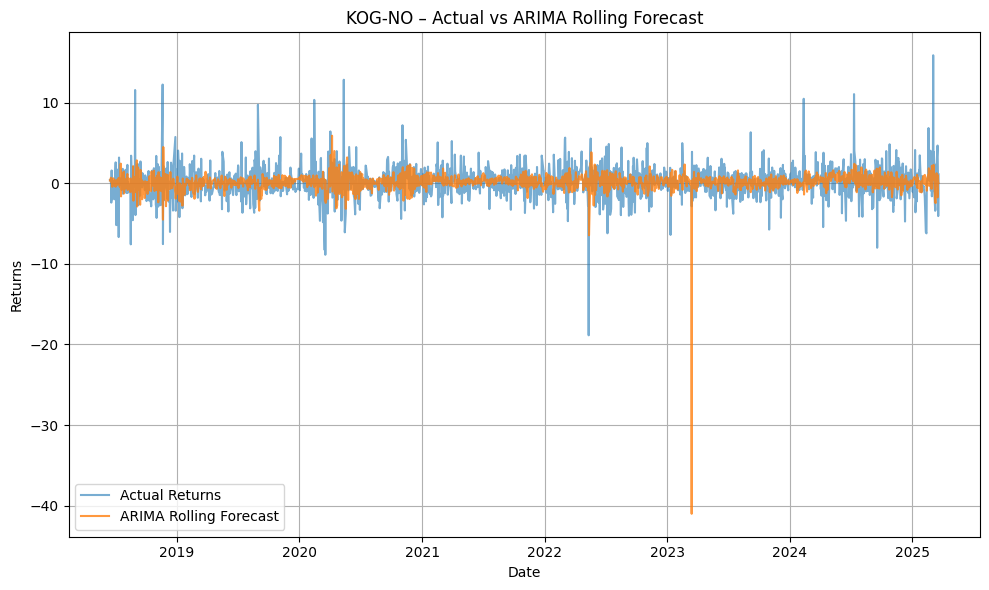

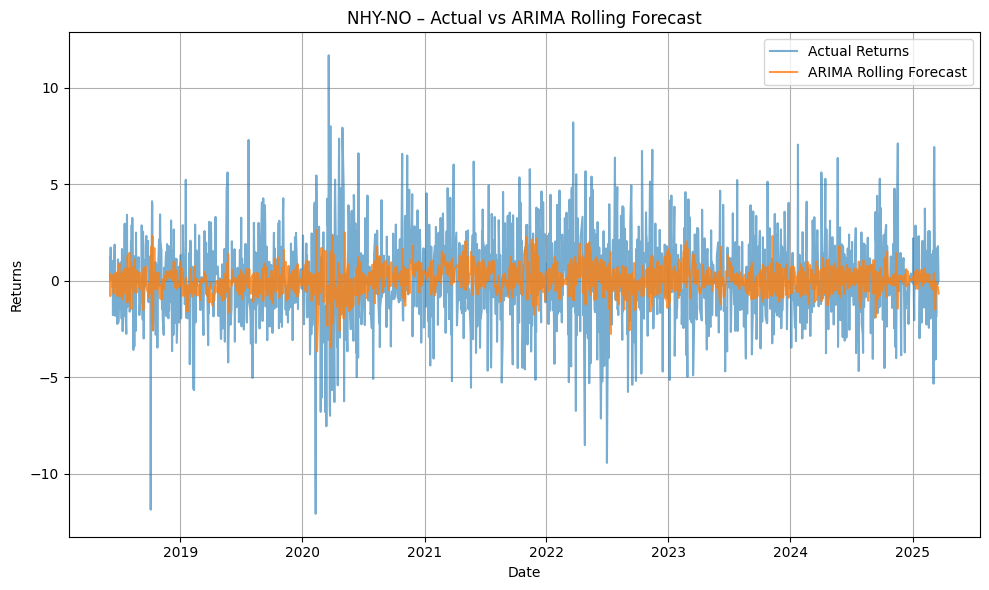

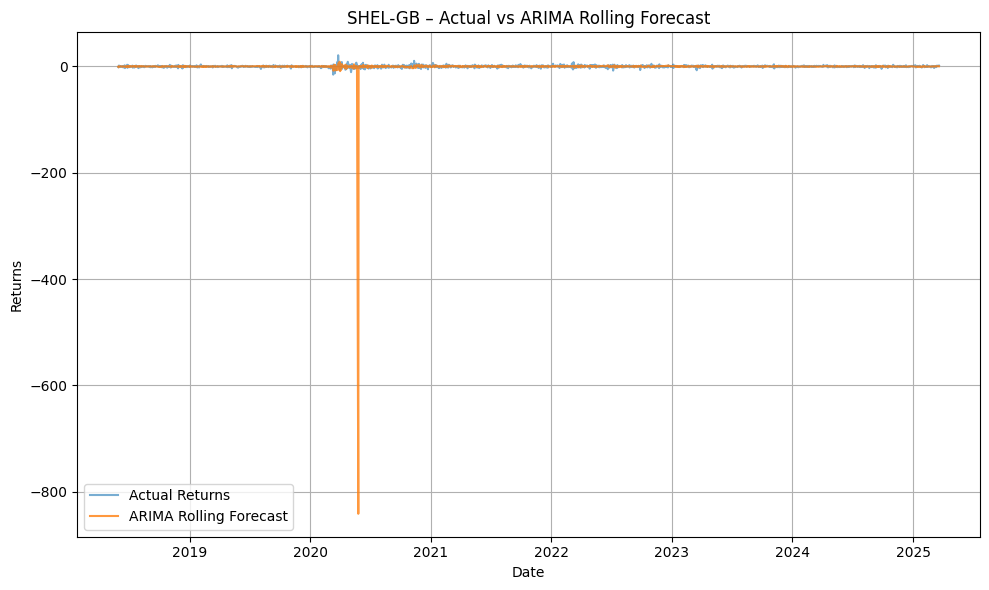

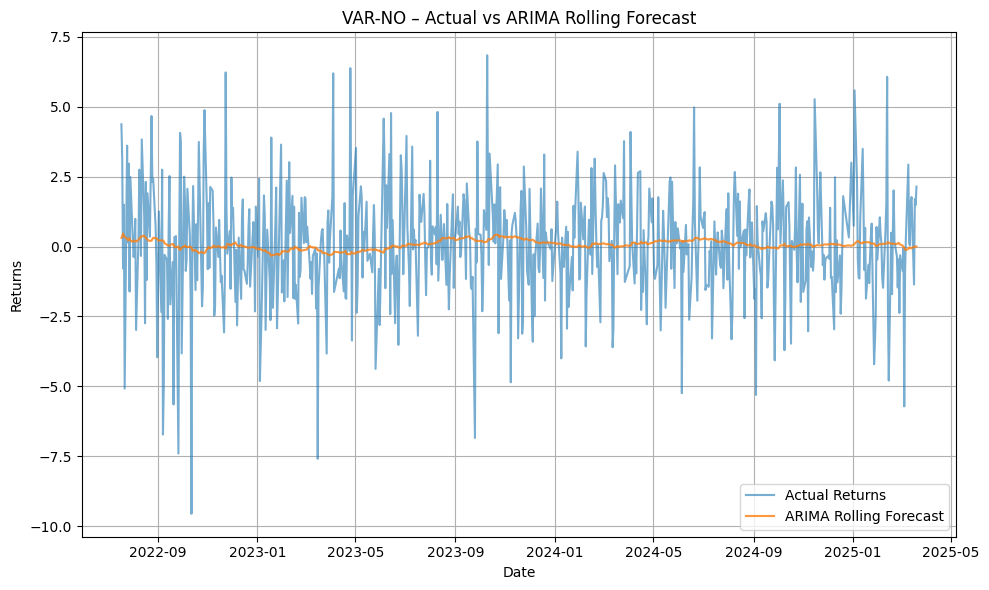

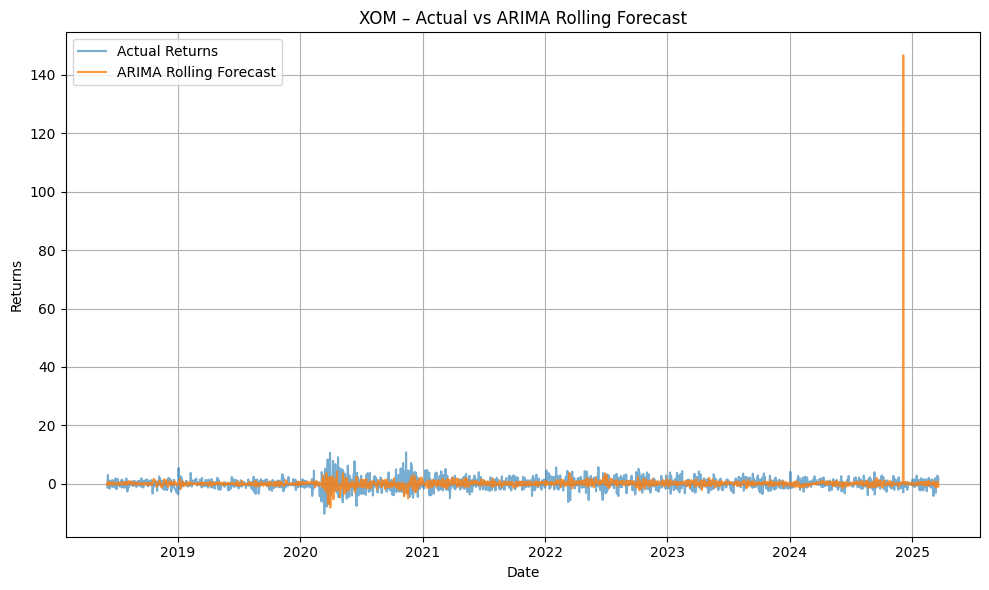

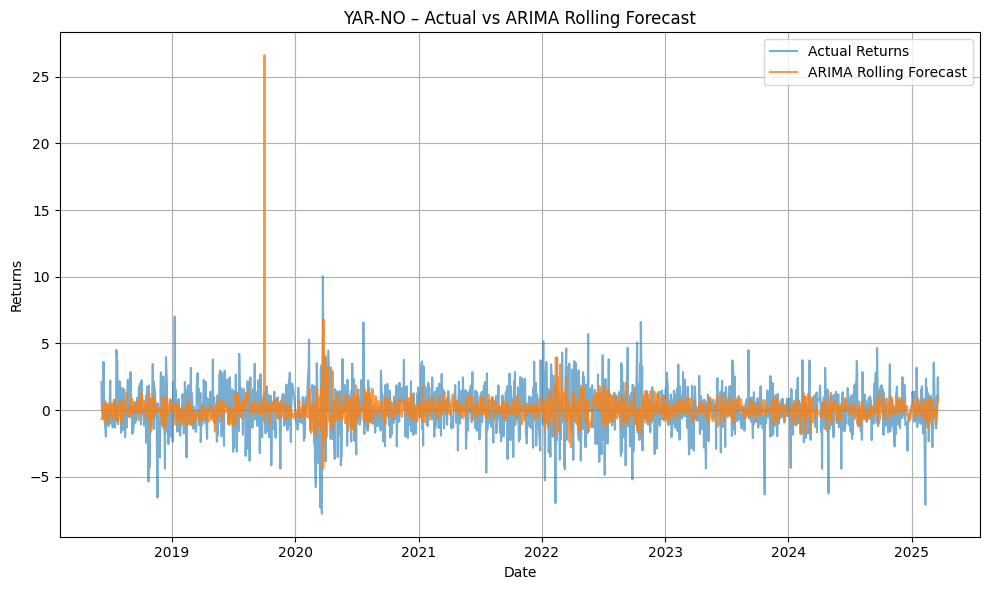

In [22]:
#For each ticker, plot the actual vs forecasted values

for key, value in stocks_dictionary.items():
    preds = value['ARIMA_Rolling_Predictions']
    actuals = value['ARIMA_Rolling_Actuals']
    dates = value['data']['Date'][-len(actuals):].reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    plt.plot(dates, actuals, label='Actual Returns', alpha=0.6)
    plt.plot(dates, preds, label='ARIMA Rolling Forecast', alpha=0.8)
    plt.title(f"{key} – Actual vs ARIMA Rolling Forecast")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [37]:
#Compare rolling and one shot ARIMA
#Summary of the results as dataframe
#Retrieve both one-shot, rolling ARIMA and rolling ARIMAX results
#RMSE, Flip-Accuracy and Sign-Accuracy

#One-shot prediction
df_one_shot = pd.DataFrame()

for ticker, results in stock_one_prediction.items():
    df_one_shot = pd.concat([df_one_shot, pd.DataFrame([{
        'Ticker': ticker,
        'ARIMA (One-Shot) RMSE': results.get('AIC_RMSE'),
    }])], ignore_index=True)

#Rolling ARIMA
df_rolling_arima = pd.DataFrame()

for ticker, results in stocks_dictionary.items():
    df_rolling_arima = pd.concat([df_rolling_arima, pd.DataFrame([{
        'Ticker': ticker,
        'ARIMA (Rolling) RMSE': results.get('ARIMA_Rolling_RMSE'),
    }])], ignore_index=True)



#Combine results to one table
model_summary = df_one_shot.merge(df_rolling_arima, on = "Ticker")
display(model_summary)


,Ticker,ARIMA (One-Shot) RMSE,ARIMA (Rolling) RMSE
0,2222-SA,0.870929,1.250084
1,AKRBP-NO,1.646457,2.798418
2,DNO-NO,2.218782,3.430697
3,DOFG-NO,1.927816,2.203927
4,EQNR-NO,1.632902,2.069162
5,KOG-NO,2.196893,2.362517
6,NHY-NO,2.016578,2.399997
7,SHEL-GB,1.063787,20.319223
8,VAR-NO,1.919051,2.029415
9,XOM,1.336063,4.152770


Visually, the rolling-window method seemingly offers much better predictions. The plots show that the predictions seemigly follow the actual values more accuratly. Although rolling window forecasts often visually align more closely with the actual series, they may result in higher RMSE values compared to one-shot predictions. This can be observed in the table above. Rolling models are re-estimated at each step using the most recent data, allowing them to better adapt to short-term dynamics and potentially shifting patterns in the time series. They operate as we would expect in real life: predictions are made best on the newest available data. However, this flexibility may cause more sensitivity to noise, leading to higher RMSE. On the other hand, one-shot models, especially those with minimal structure like ARIMA(0,0,0), often predict the mean of the series, which minimizes RMSE but lacks any informative predictive power. As we are interested in realistic, adaptive forecasting, rolling forecasts offer more value. Brooks (2019, pg. 287) highlights the limitation of RMSE in measuring predictive power, and suggests other evaluation methods, discussed in section "Evaluating the Model". 


However, rolling predictions are way more computationally expensive than the one-shot predictions. Instead of fitting one ARMA model for each stock, each stock’s return is predicted using many ARMA models. In fact, a new ARMA model is fitted for every day, excluding the first 100 days of the time-series. This leads to much longer running times, with the whole prediction process taking 21 minutes in total for all stocks. 




#### ARIMAX prediction

<span style="color:red;">OBS OBS Hans Kristian: dette må fortsatt implementeres! Hva er exogenous variables?<span>

In [ ]:
#results_arimax = evaluate_arima_or_arimax_rolling(stocks_dictionary, window_size=100, model_type="ARIMAX", exog_key=None)


In [ ]:
""" for key, value in stocks_dictionary.items():
    preds = value['ARIMAX_Rolling_Predictions']
    actuals = value['ARIMAX_Rolling_Actuals']
    dates = value['data']['Date'][-len(actuals):].reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    plt.plot(dates, actuals, label='Actual Returns', alpha=0.6)
    plt.plot(dates, preds, label='ARIMAX Rolling Forecast', alpha=0.8)
    plt.title(f"{key} – Actual vs ARIMAX Rolling Forecast")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show() """

#### Evaluating the Model


Up until now, the model’s have largely been evaluated on a visual basis. However, it is essential to define metrics which quantify how accurate a prediction is. This can be done using the Root Mean Squared Error (RMSE) metric, which is common to use in prediction evaluation. The advantage of RMSE compared to MSE is that it is in the same unit as the original data. For financial forecasting, however, it may be more appropriate to use metrics which capture how well a model predicts the sign of future return or turning points in a series (Books, pg.287). Imagine the actual return being 3%, and we have two different predictions to evaluate: -2% and 9%. RMSE would prefer the first prediction, as it is numerically closer to the actual return.

However, in a financial context, the +9% prediction may be more useful, as it correctly predicts a positive return, potentially leading to the right trading decision. Therefore, this project also used share of correctly predicted signs of future returns and correctly predicted turning points as an evaluation metric. This is already implemented in the evaluate_arima_arimax_rolling function above.

Below follows a summary comparing the various model's performances.

<span style="color:red;">OBS OBS Hans Kristian: her må ARIMAX med!!! Se det som er kommentert ut<span>

In [35]:
#Summary of the results as dataframe
#Retrieve both one-shot, rolling ARIMA and rolling ARIMAX results
#RMSE, Flip-Accuracy and Sign-Accuracy

#One-shot prediction
df_one_shot = pd.DataFrame()

for ticker, results in stock_one_prediction.items():
    df_one_shot = pd.concat([df_one_shot, pd.DataFrame([{
        'Ticker': ticker,
        'Model': 'ARIMA One-Shot',
        'ARIMA (One-Shot) RMSE': results.get('AIC_RMSE'),
        'ARIMA (One-Shot) Accuracy': results.get('AIC_sign_accuracy'),
        'ARIMA (One-Shot) Flip Accuracy': results.get('Flip accuracy')
    }])], ignore_index=True)

#Rolling ARIMA
df_rolling_arima = pd.DataFrame()

for ticker, results in stocks_dictionary.items():
    df_rolling_arima = pd.concat([df_rolling_arima, pd.DataFrame([{
        'Ticker': ticker,
        'Model': 'ARIMA Rolling',
        'ARIMA (Rolling) RMSE': results.get('ARIMA_Rolling_RMSE'),
        'ARIMA (Rolling) Sign Accuracy': results.get('ARIMA_Rolling_Sign_Accuracy'),
        'ARIMA (Rolling) Flip Accuracy': results.get('ARIMA_Rolling_Flip_Accuracy')
    }])], ignore_index=True)


#ARIMAX
""" df_rolling_arimax = pd.DataFrame()

for ticker, results in stocks_dictionary.items():
    df_one_shot = pd.concat([df_one_shot, pd.DataFrame([{
        'Ticker': ticker,
        'Model': 'ARIMA Rolling',
        'ARIMAX RMSE': results.get('ARIMAX_Rolling_RMSE'),
        'ARIMAX Sign Accuracy': results.get('ARIMAX_Rolling_Sign_Accuracy'),
        'ARIMAX Flip Accuracy': results.get('ARIMAX_Rolling_Flip_Accuracy')
    }])], ignore_index=True) """

#Combine results to one table
model_summary = df_one_shot.merge(df_rolling_arima, on = "Ticker")
model_summary = model_summary.drop(columns=['Model_x', 'Model_y'])
display(model_summary)

,Ticker,ARIMA (One-Shot) RMSE,ARIMA (One-Shot) Accuracy,ARIMA (One-Shot) Flip Accuracy,ARIMA (Rolling) RMSE,ARIMA (Rolling) Sign Accuracy,ARIMA (Rolling) Flip Accuracy
0,2222-SA,0.870929,0.500000,0.486692,1.250084,0.496711,0.516049
1,AKRBP-NO,1.646457,0.487465,0.483240,2.798418,0.499704,0.479882
2,DNO-NO,2.218782,0.526462,0.564246,3.430697,0.490555,0.500886
3,DOFG-NO,1.927816,0.488636,0.482759,2.203927,0.514881,0.480597
4,EQNR-NO,1.632902,0.494444,0.520891,2.069162,0.494991,0.493514
5,KOG-NO,2.196893,0.602273,0.515670,2.362517,0.509970,0.495768
6,NHY-NO,2.016578,0.497207,0.434174,2.399997,0.515708,0.471530
7,SHEL-GB,1.063787,0.528767,0.497253,20.319223,0.512776,0.513074
8,VAR-NO,1.919051,0.529032,0.590909,2.029415,0.519345,0.523100
9,XOM,1.336063,0.523416,0.469613,4.152770,0.488005,0.515808


The above results may be surprising. Despite incorporatinng more recent data at each forecasting step, rolling windows ARIMA models do not consitently outperform a simple one-shot model, which essentially reverts to the mean of the stock returns. Across most stocks, the one-shot ARIMA models have both lower RMSE and comparable or just slightly better sign and flig accuracy. 

This reflects the unpredictability and noise in daily return data, where even models capturing short-term autocorrelation fail to produce reliable improvements. Our project results suggest that daily returns follow a white noise prorgress, which aligns with financial theory learned in other courses. These findings highlight the challenges of forecasting on financial data.  

## 